# Загрузка Датасета

In [1]:
import os
!mkdir Data
os.environ['KAGGLE_USERNAME'] = "jackira" # username from the json file
os.environ['KAGGLE_KEY'] = "d268cc116aa8a011c44bc304dc1b83d2" # key from the json file


!kaggle datasets download -d mikaelstrauhs/airbus-ship-detection-train-set-70 -p /content/Data

100% 18.5G/18.5G [03:54<00:00, 97.0MB/s]
100% 18.5G/18.5G [03:54<00:00, 84.8MB/s]


# Распаковка Датасета

In [2]:
!mkdir /content/Data



In [2]:
import zipfile
         
fantasy_zip = zipfile.ZipFile('/content/Data/airbus-ship-detection-train-set-70.zip')
fantasy_zip.extractall('/content/Data/')
 
fantasy_zip.close()

In [9]:
!rm  Data/*.zip

# Параметыр модели

In [10]:
BATCH_SIZE = 256
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = "SIMPLE"

#Понижение дискритизации внутри сети
NET_SCALING = (1, 1)

#Понижение размерности в предобработке
IMG_SCALING = (3, 3)

#Число изображений для валидации
VALID_IMG_COUNT = 900

#Максимальное число шагов за эпоху при обучении
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 50
AUGMENT_BRIGHTNESS = True

SEED = 42

In [11]:
from skimage.util import montage
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
import keras.backend as K
import torch

from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam

import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()


from skimage.morphology import binary_opening, disk, label
import gc; gc.enable()

from PIL import Image

import keras

In [12]:
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)
print("Numpy version: ", np.__version__)
gc.enable()

Tensorflow version:  2.5.0
Keras version:  2.5.0
Numpy version:  1.19.5


In [31]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = "/content/Data/"
train_image_dir = os.path.join(ship_dir, 'train_v3/train_v3/Images')

## Определим вспомогательные процедуры для декодирования, кодирования и вывода изображения и маски корабля

In [32]:
def rle_encode(img, min_max_treshold = 1e-3, max_mean_treshold = None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Возвращает бегущую строку как форматированную
    '''
    if (np.max(img) < min_max_treshold):
        return ''
    if (max_mean_treshold and np.mean(img) > max_mean_treshold):
        return ''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [33]:
def multi_rle_encode(img, **kwargs):
    '''
    Кодируем объединенные регионы как разделители масок
    '''
    labels = label(img)
    if img.ndim > 2:
      return [rle_encode(np.sum(labels == k, axis = 2), **kwargs) for k in np.unique(labels[labels > 0])]
    else:
        return [rle_encode(labels == k, **kwargs) for k in np.unique(labels[labels > 0])]


In [34]:
def rle_decode(mask_rle, shape = (768, 768)):
    '''
    mask_rle: бегущая - длина как форматированная строка (start length)
    shape: (height,width) массив для возвратного значения 
    Возвращаем  numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype = int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [35]:
def masks_as_image(in_mask_list):
    #Берем индивидуальную маску корабля и создаем отдельный массив масок для всех кораблей
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks


In [36]:
def masks_as_color(in_mask_list):
    #Берем индивидуальную маску корабля и создаем цветовую маску для каждого корабля
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list) + x + 1) / (len(in_mask_list) * 2)
    for i, mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:, :] += scale(i) * rle_decode(mask)
    return all_masks


## Продемонстрируем работу

In [37]:
masks = pd.read_csv(ship_dir + "train_ship_segmentations_v3.csv")
masks

,ImageId,EncodedPixels
0,0001124c7.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
3,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
4,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
...,...,...
162086,fffedbb6b.jpg,NaN
162087,ffff2aa57.jpg,NaN
162088,ffff6e525.jpg,NaN
162089,ffffc50b4.jpg,NaN


In [38]:
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), "masks in", masks[not_empty].ImageId.nunique(), 'Images')
print((~not_empty).sum(), "empty images in", masks.ImageId.nunique(), "total images")

57108 masks in 29806 Images
104983 empty images in 134789 total images


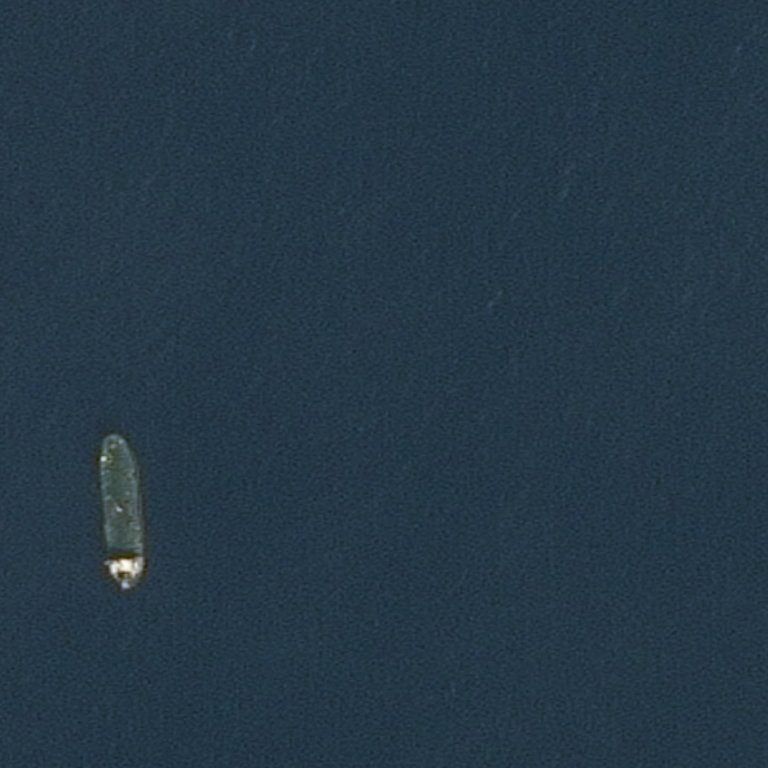

In [42]:
im_name = os.listdir(train_image_dir)[1]
im = Image.open(train_image_dir + "/" + im_name)
im

Проверка Декодирования -> Кодирование RLE_0: 1 -> RLE_1: 1
0.0 error


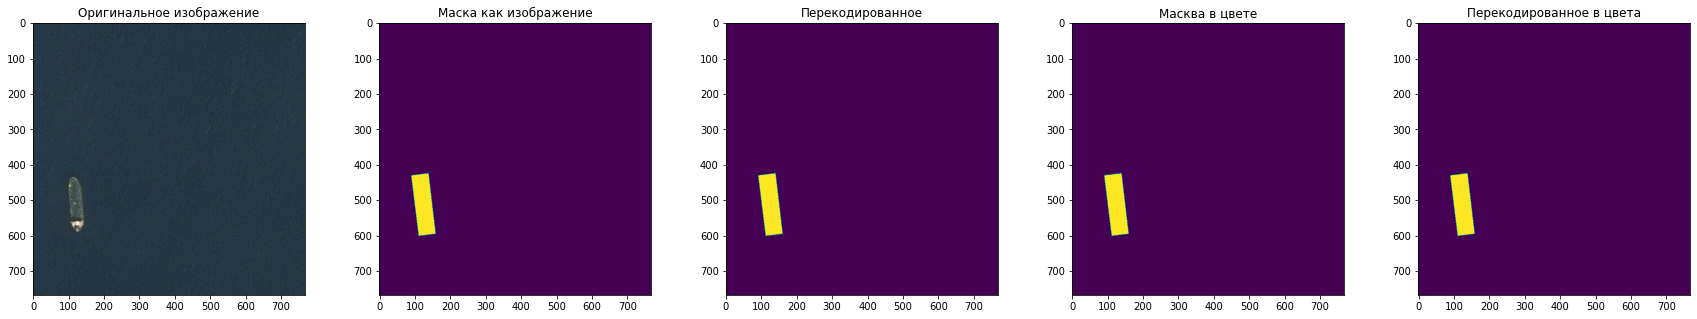

In [43]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize = (30, 5))
rle_0 = masks.query('ImageId == "{0}"'.format(im_name))["EncodedPixels"]
img_0 = masks_as_image(rle_0)
ax0.imshow(im)
ax0.set_title("Оригинальное изображение")

ax1.imshow(img_0)
ax1.set_title("Маска как изображение")

rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_color(rle_0)
ax2.imshow(img_1)
ax2.set_title("Перекодированное")

img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title("Масква в цвете")

img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title("Перекодированное в цвета")
print("Проверка Декодирования -> Кодирование", 'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

<h1> Разделим данные на тренировочные и проверочные</h1>

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
16153,361672d2c.jpg,0,0.0,[0.0],218.174805
47887,8075186a5.jpg,0,0.0,[0.0],227.940430
14778,3306e9425.jpg,0,0.0,[0.0],111.883789
76245,b23036667.jpg,0,0.0,[0.0],121.696289
37662,66fcf5a12.jpg,0,0.0,[0.0],119.865234
129307,f8ce83e83.jpg,0,0.0,[0.0],167.113281
31780,59478f3f5.jpg,1,1.0,[1.0],177.078125
18168,403351dad.jpg,1,1.0,[1.0],106.401367
64873,a3153029e.jpg,0,0.0,[0.0],117.488281
133234,fdf74977d.jpg,0,0.0,[0.0],174.855469


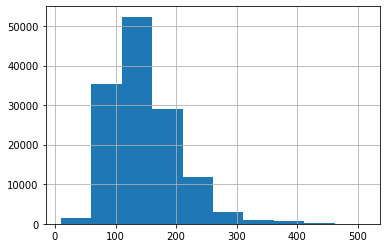

In [44]:
#Поле, указывающее, есть ли корабль на картинке:  1 - есть, 0 - нет
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)    
unique_img_ids = masks.groupby("ImageId").agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis = 1, inplace = True)
unique_img_ids.sample(10)

## Построим гистограмму от числа кораблей (копий изображения) для одного файла

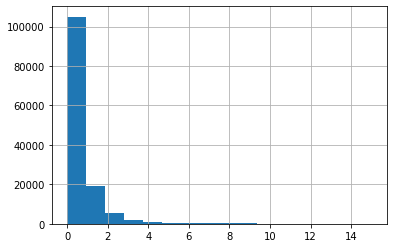

In [45]:
unique_img_ids['ships'].hist(bins= unique_img_ids['ships'].max() + 1)

======================== МЕСТО ДЛЯ ОТСЕИВАНИЯ ДУБЛИКАТОВ ===========================

## Разделим на тренироочную и тестовую выборку

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
52004,85f6c66e1.jpg,0,0.0,[0.0],185.690430
19069,421a7fe71.jpg,0,0.0,[0.0],124.644531
59725,963d6ec1b.jpg,0,0.0,[0.0],90.708008
71713,ac34a30dd.jpg,0,0.0,[0.0],114.281250
32971,60d8605f5.jpg,0,0.0,[0.0],197.306641
63085,a0a602887.jpg,0,0.0,[0.0],128.910156
32518,6032c1f3a.jpg,0,0.0,[0.0],115.330078


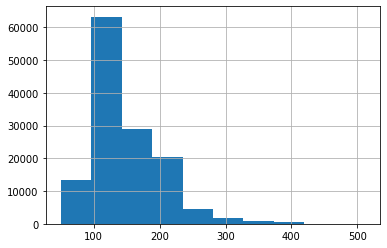

In [46]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

54412 masks


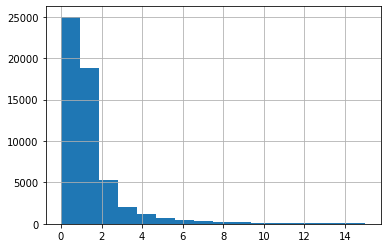

In [53]:
SAMPLES_PER_GROUP = 25000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')



In [54]:
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.25, random_state = SEED)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)

print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

120768 training masks
40193 validation masks


In [55]:
'''
train_df = train_df[train_df['has_ship'] == 1.0]
train_df['has_ship'].value_counts()
'''

"\ntrain_df = train_df[train_df['has_ship'] == 1.0]\ntrain_df['has_ship'].value_counts()\n"

## Декодируем данные в изображения

In [56]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []


In [57]:
"""
x (2048, 256, 256, 3) 0.0 1.0
y (2048, 256, 256, 1) 0 1
"""
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())


x (256, 256, 256, 3) 0.0 1.0
y (256, 256, 256, 1) 0 1


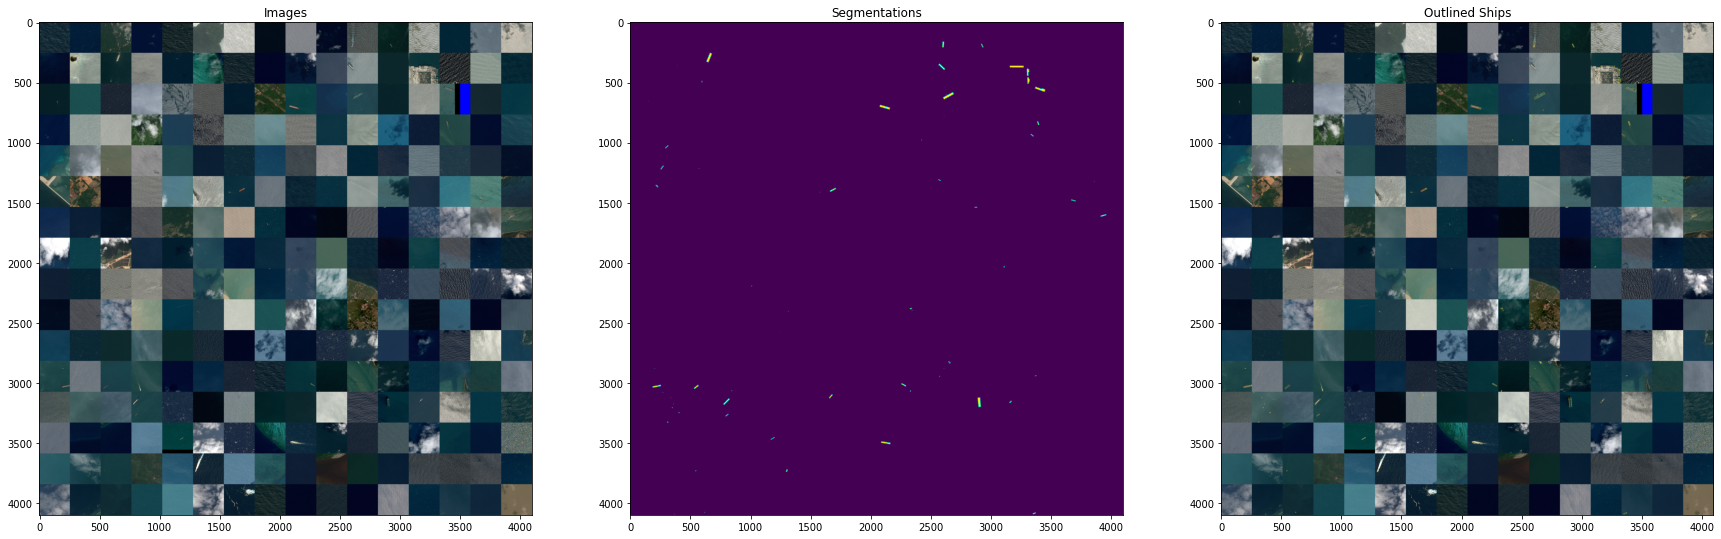

In [58]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')


## Сделаем набор для проверки

In [ ]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

In [ ]:
valid_x

In [ ]:
valid_x[0]

In [ ]:
s = 10
j = 0
for r in valid_y[-17]:
    k = 10
    i = 0
    for c in r:
        if(i > k):
            print("...")
            break;
        print(c, sep=' ', end='', flush=True)
        i += 1
    print
    j += 1
    if(j > k):
            print("...")
            break;

##Дополним данные

In [ ]:
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  fill_mode = 'reflect',
                  data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args['brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [ ]:

"""
x (64, 256, 256, 3) float32 0.0 1.0
y (64, 256, 256, 1) float32 0.0 1.0
"""
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')


In [ ]:
gc.collect()

## Соберем модель

In [ ]:
#https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
#https://keras.io/api/metrics/segmentation_metrics/#image-segmentation-metrics
#https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch#BCE-Dice-Loss
#https://www.kaggle.com/qiuzy8/focal-tversky-loss
'''
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / denominator

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

def dice_loss(inp, target):
    input = torch.sigmoid(inp)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
'''
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float64')
    y_pred = K.cast(y_pred, 'float64')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
    
def true_positive_rate( y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


def dice_loss(y_true, y_pred):
    return 1 - dice_coef( y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 4

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):  
    
    y_true = K.cast(targets, 'float64')
    y_pred = K.cast(inputs, 'float64') 
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss


def binary_iou_focal_loss(gamma=2, alpha=0.25):
    """
    Binary form of focal loss.
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        eps=1e-6
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        
        smooth=1
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1-y_pred_pos))
        false_pos = K.sum((1-y_true_pos)*y_pred_pos)
        alpha1 = 0.7
        loss1=(true_pos + smooth)/(true_pos + alpha1*false_neg + (1-alpha1)*false_pos + smooth)
        
        loss2=(1.-loss1)+focal_loss
        
        return K.mean(loss2)
    return binary_focal_loss_fixed








In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
def GetUnetModel():
    # Build U-Net model
    def upsample_conv(filters, kernel_size, strides, padding):
        return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
    def upsample_simple(filters, kernel_size, strides, padding):
        return layers.UpSampling2D(strides)

    if UPSAMPLE_MODE=='DECONV':
        upsample=upsample_conv
    else:
        upsample=upsample_simple
        
    input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
    pp_in_layer = input_img

    if NET_SCALING is not None:
        pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
        
    pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
    pp_in_layer = layers.BatchNormalization()(pp_in_layer)

    filter_num = 16

    c1 = layers.Conv2D(filter_num, (3, 3), activation='relu', padding='same') (pp_in_layer)
    c1 = layers.Conv2D(filter_num, (3, 3), activation='relu', padding='same') (c1)
    c1 = layers.Dropout(0.25) (c1)
    p1 = layers.MaxPooling2D((2, 2)) (c1)

    c2 = layers.Conv2D(filter_num*2, (3, 3), activation='relu', padding='same') (p1)
    c2 = layers.Conv2D(filter_num*2, (3, 3), activation='relu', padding='same') (c2)
    c2 = layers.Dropout(0.25) (c2)
    p2 = layers.MaxPooling2D((2, 2)) (c2)

    c3 = layers.Conv2D(filter_num*4, (3, 3), activation='relu', padding='same') (p2)
    c3 = layers.Conv2D(filter_num*4, (3, 3), activation='relu', padding='same') (c3)
    c3 = layers.Dropout(0.25) (c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)

    c4 = layers.Conv2D(filter_num*8, (3, 3), activation='relu', padding='same') (p3)
    c4 = layers.Conv2D(filter_num*8, (3, 3), activation='relu', padding='same') (c4)
    c4 = layers.Dropout(0.25) (c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


    c5 = layers.Conv2D(filter_num*16, (3, 3), activation='relu', padding='same') (p4)
    c5 = layers.Conv2D(filter_num*16, (3, 3), activation='relu', padding='same') (c5)
    c5 = layers.Dropout(0.25) (c5)

    u6 = upsample(filter_num*8, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filter_num*8, (3, 3), activation='relu', padding='same') (u6)
    c6 = layers.Conv2D(filter_num*8, (3, 3), activation='relu', padding='same') (c6)

    u7 = upsample(filter_num*4, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filter_num*4, (3, 3), activation='relu', padding='same') (u7)
    c7 = layers.Conv2D(filter_num*4, (3, 3), activation='relu', padding='same') (c7)

    u8 = upsample(filter_num*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filter_num*2, (3, 3), activation='relu', padding='same') (u8)
    c8 = layers.Conv2D(filter_num*2, (3, 3), activation='relu', padding='same') (c8)

    u9 = upsample(filter_num, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(filter_num, (3, 3), activation='relu', padding='same') (u9)
    c9 = layers.Conv2D(filter_num, (3, 3), activation='relu', padding='same') (c9)

    d = layers.Dropout(0.25) (c9)
    d = layers.Conv2D(1, (1, 1), activation='sigmoid') (d)
    # d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
    # d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
    if NET_SCALING is not None:
        d = layers.UpSampling2D(NET_SCALING)(d)


    return models.Model(inputs=[input_img], outputs=[d])

In [ ]:

    
weight_path="/content/drive/MyDrive/Диплом/Ship_detection/weights/u_net/{}_weights.best.hdf5".format('FULL_seg_model_dice_loss_DropOut_RMS_more_filter')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, GarbageCollectorCallback(), reduceLROnPlat]#, reduceLROnPlat]

RMS = RMSprop( learning_rate=0.001,
                        rho=0.9,
                        momentum=0.0,
                        epsilon=1e-07,
                        centered=False,
                        name="RMSprop")
        
adam = Adam(learning_rate=0.001,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07,
                    amsgrad=False,
                    name="Adam")
seg_model = GetUnetModel()
seg_model.compile(optimizer = RMS, loss= dice_loss, metrics=['binary_accuracy',  dice_coef, true_positive_rate])
    #weight_path1="/content/drive/MyDrive/Диплом/Ship_detection/weights/u_net/{}_weights.best.hdf5".format('seg_model')
    #seg_model.load_weights(weight_path1)

seg_model.summary()

In [ ]:
image_file = 'model_1.png'
tf.keras.utils.plot_model(seg_model, to_file = image_file, show_shapes = True)

In [ ]:
gc.collect()

In [ ]:
step_count = MAX_TRAIN_STEPS
step_count = train_df.shape[0]//BATCH_SIZE
aug_gen = create_aug_gen(make_image_gen(train_df))
loss_history = [seg_model.fit(aug_gen, 
                                 steps_per_epoch=step_count,
                                 batch_size = BATCH_SIZE,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list
                                )]

In [ ]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

    _ = ax3.plot(epochs, np.concatenate([mh.history['dice_coef'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_dice_coef'] for mh in loss_history]), 'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('DICE Coefficient (%)')

    _ = ax4.plot(epochs, np.concatenate([mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_true_positive_rate'] for mh in loss_history]), 'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('TFP')



    fig.savefig('/content/drive/MyDrive/Диплом/Ship_detection/FULL_UNET_dice_loss_DropOut_RMS_more_filter_hist.png')

show_loss(loss_history)



In [ ]:
gc.collect()


In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('/content/drive/MyDrive/Диплом/Ship_detection/weights/u_net/FULL_seg_dice_loss_DropOut_RMS_more_filter_model.h5')

In [ ]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

## Подготовка для полноразмерной модели

In [ ]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('/content/drive/MyDrive/Диплом/Ship_detection/weights/u_net/FULL_fullres_dice_loss_DropOut_RMS_more_filter_model.h5')

In [ ]:
gc.collect()


## Визуализируем предсказание

In [ ]:
def raw_prediction(img, path=train_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))

def predict(img, path=train_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img


## Get a sample of each group of ship count
n_samples = 10
samples = valid_df.groupby('ships').apply(lambda x: x.sample(n_samples, random_state = SEED, replace= False))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('/content/drive/MyDrive/Диплом/Ship_detection/FULL_UNET_dice_loss_DropOut_RMS_more_filter.png')
plt.show()